In [1]:
import os
from collections import Counter

data_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

class_counts = {}

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)
    if os.path.isdir(class_folder):
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

total_images = sum(class_counts.values())

class_proportions = {class_name: count / total_images for class_name, count in class_counts.items()}

print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")

Class Proportions:
tomato_fully_ripened: 0.01
tomato_half_ripened: 0.01
banana_overripe: 0.21
banana_rotten: 0.30
banana_unripe: 0.21
banana_ripe: 0.22
tomato_green: 0.05


## ViT Model in tensorflow

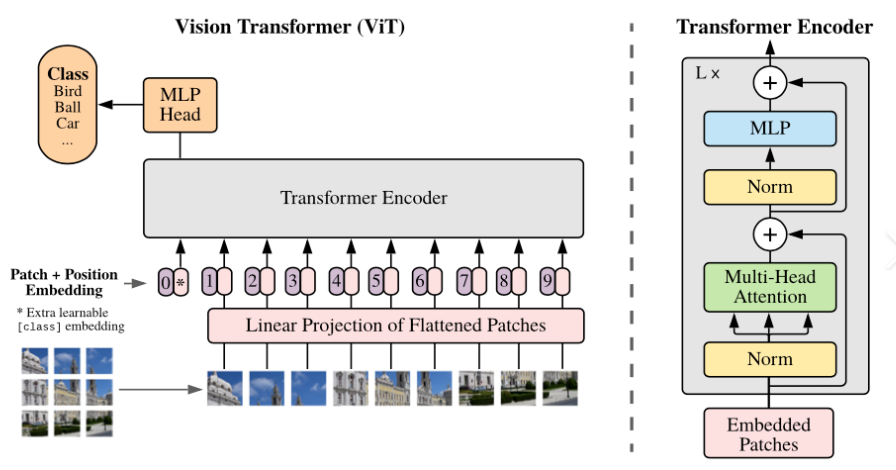

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, Model
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

2025-05-17 13:05:01.397255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747487101.929407      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747487102.069723      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
IMG_SIZE = (224, 224)
PATCH_SIZE = 8
PROJECTION_DIM = 128
NUM_HEADS = 8
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]
# Removed DROPOUT_RATE = 0.01

# Custom Layers for Vision Transformer
class PatchCreation(layers.Layer):
    def __init__(self, patch_size):
        super(PatchCreation, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(projection_dim)
        
    def call(self, patches):
        return self.projection(patches)

class PositionEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PositionEmbedding, self).__init__()
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        
    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = patches + self.position_embedding(positions)
        return encoded

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerEncoderBlock, self).__init__()
        
        # Removed dropout from MultiHeadAttention
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Removed dropout from MLP
        self.mlp = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="gelu"),
            layers.Dense(embed_dim)
        ])
        
    def call(self, inputs, training=True):
        # Apply Layer Normalization before attention
        x1 = self.layernorm1(inputs)
        attention_output = self.attention(x1, x1, training=training)
        x2 = attention_output + inputs
        
        # Apply Layer Normalization before MLP
        x3 = self.layernorm2(x2)
        x4 = self.mlp(x3, training=training)
        return x2 + x4

# Main Vision Transformer Model
def create_vit_model(input_shape, patch_size, num_classes, projection_dim, 
                     num_heads, transformer_layers, mlp_head_units):
    # Calculate number of patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    inputs = layers.Input(shape=input_shape)
    
    # No normalization layer since we already normalized in generator
    # Create patches from images
    patches = PatchCreation(patch_size)(inputs)
    
    # Create patch embeddings
    embedding_layer = PatchEmbedding(num_patches, projection_dim)
    embeddings = embedding_layer(patches)
    
    # Add positional embeddings
    position_embedding = PositionEmbedding(num_patches, projection_dim)
    encoded_patches = position_embedding(embeddings)
    
    # Removed dropout after embeddings
    x = encoded_patches
    
    # Create Transformer Encoder blocks
    for _ in range(transformer_layers):
        x = TransformerEncoderBlock(
            projection_dim, num_heads, projection_dim * 4
        )(x)
    
    # Layer Normalization and Global Average Pooling
    representation = layers.LayerNormalization(epsilon=1e-6)(x)
    representation = layers.GlobalAvgPool1D()(representation)
    
    # MLP Head for classification - removed dropout
    features = representation
    for units in mlp_head_units:
        features = layers.Dense(units, activation="gelu")(features)
    
    # Final classification layer
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to handle class imbalance
def calculate_class_weights(generator):
    # Get labels from generator
    y = []
    num_samples = 0
    
    for i in range(len(generator)):
        if num_samples >= generator.samples:
            break
        batch_x, batch_y = generator[i]
        y.extend(batch_y.astype(np.int64))
        num_samples += len(batch_y)
    
    # Reset generator
    generator.reset()
    
    y = np.array(y)
    class_counts = np.bincount(y)
    total_samples = np.sum(class_counts)
    n_classes = len(class_counts)
    
    # Calculate class weights
    class_weights = {}
    for i in range(n_classes):
        if class_counts[i] > 0:
            class_weights[i] = total_samples / (n_classes * class_counts[i])
        else:
            class_weights[i] = 1.0
    
    return class_weights

def analyze_class_distribution(generator):
    labels = []
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        labels.extend(batch_y)
    
    # Reset generator after reading
    generator.reset()
    
    # Plot class distribution
    plt.figure(figsize=(15, 6))
    
    unique, counts = np.unique(labels, return_counts=True)
    class_names = list(generator.class_indices.keys())
    
    plt.bar(range(len(counts)), counts)
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()
    
    print("Class distribution:")
    for i, count in enumerate(counts):
        print(f"{class_names[i]}: {count} samples")
    
    # Check for class imbalance
    min_samples = np.min(counts)
    max_samples = np.max(counts)
    imbalance_ratio = max_samples / min_samples
    
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    return labels, counts

def compile_and_train_model(model, train_data, val_data, class_weights, epochs=50):
    # Define callbacks
    callbacks = [
        ModelCheckpoint(
            'best_vit_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss='sparse_categorical_crossentropy',  # Use sparse since class_mode='sparse'
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def create_submission_csv(model, test_generator, output_file='/kaggle/working/submission.csv'):    
    # Get predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get file paths and ids
    test_generator.reset()
    filenames = test_generator.filenames
    
    # Extract ids from filenames (assuming format like: id.jpg)
    # ids = [os.path.splitext(os.path.basename(filename))[0] for filename in filenames]
    ids = [os.path.basename(filename) for filename in filenames]  

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ImageID': ids,
        'Class': predicted_classes
    })
    
    # Save to CSV
    submission_df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")
    print("\nFirst 10 predictions:")
    print(submission_df.head(10))
    
    return submission_df

def evaluate_model(model, val_generator):
    """Evaluate model performance"""
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    return val_loss, val_accuracy

In [4]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable mixed precision for faster training if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_policy(policy)
        print('Mixed precision enabled')
    except:
        print('Mixed precision not available')

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# Your existing data generators
data = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    validation_split=0.05,       
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    zoom_range=0.1,              # Slight zooming
    width_shift_range=0.1,       # Slight horizontal shift
    height_shift_range=0.1,      # Slight vertical shift
    shear_range=0.1,             # Shearing transformation
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill in missing pixels after rotation/shift
)

# Load training data
trainData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Uses label encoding
    shuffle=True,
    subset='training'  
)

# Load validation data
valData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

# Load test data
testData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,  # No labels for test data
    shuffle=False
)

# Display dataset information
print(f"Training data: {trainData.samples} samples")
print(f"Validation data: {valData.samples} samples")
print(f"Test data: {testData.samples} samples")
print(f"Number of classes: {len(trainData.class_indices)}")
print(f"Classes: {list(trainData.class_indices.keys())}")

Num GPUs Available:  2
Mixed precision not available
Found 6657 images belonging to 7 classes.
Found 738 images belonging to 7 classes.
Found 2484 images belonging to 1 classes.
Training data: 6657 samples
Validation data: 738 samples
Test data: 2484 samples
Number of classes: 7
Classes: ['banana_overripe', 'banana_ripe', 'banana_rotten', 'banana_unripe', 'tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']


In [5]:
print(trainData.class_indices)

{'banana_overripe': 0, 'banana_ripe': 1, 'banana_rotten': 2, 'banana_unripe': 3, 'tomato_fully_ripened': 4, 'tomato_green': 5, 'tomato_half_ripened': 6}



Analyzing class distribution...


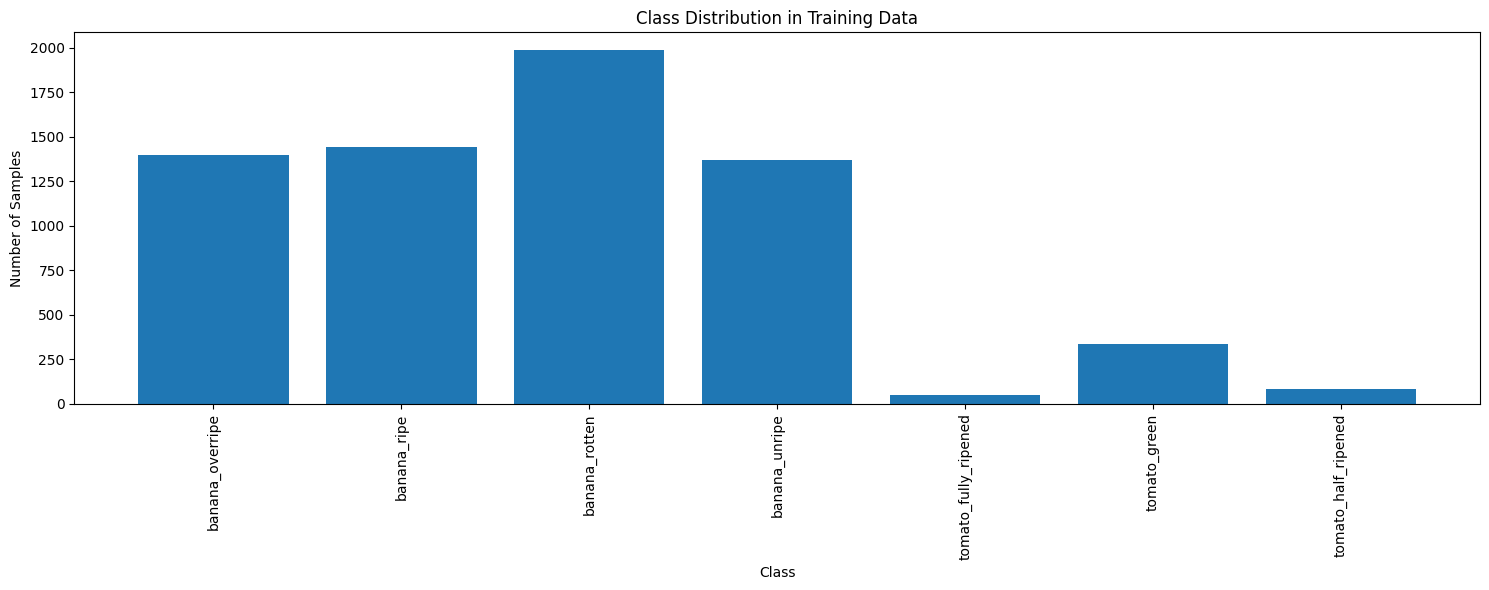

Class distribution:
banana_overripe: 1395 samples
banana_ripe: 1440 samples
banana_rotten: 1987 samples
banana_unripe: 1370 samples
tomato_fully_ripened: 50 samples
tomato_green: 334 samples
tomato_half_ripened: 81 samples
Imbalance ratio (max/min): 39.74


In [6]:
# Analyze class distribution
print("\nAnalyzing class distribution...")
labels, counts = analyze_class_distribution(trainData)

In [7]:
# Calculate class weights to handle imbalanced data
print("\nCalculating class weights...")
class_weights = calculate_class_weights(trainData)
print("Class weights:", class_weights)


Calculating class weights...
Class weights: {0: 0.6817204301075269, 1: 0.6604166666666667, 2: 0.47861097131353797, 3: 0.6941605839416058, 4: 19.02, 5: 2.8473053892215567, 6: 11.74074074074074}


In [22]:
# Create the Vision Transformer model
print("\nCreating Vision Transformer model...")
NUM_CLASSES = len(trainData.class_indices)
INPUT_SHAPE = (*IMG_SIZE, 3)

model = create_vit_model(
    input_shape=INPUT_SHAPE,
    patch_size=16,
    num_classes=NUM_CLASSES,
    projection_dim=128,
    num_heads=8,
    transformer_layers=8,
    mlp_head_units=[2048, 1024],
)

# Print model summary
print("\nModel Summary:")
model.summary()


Creating Vision Transformer model...

Model Summary:


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_creation_3 (PatchCreation)     │ (None, None, 768)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding_3 (PatchEmbedding)   │ (None, None, 128)           │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ position_embedding_3                 │ (None, 196, 128)            │          25,088 │
│ (PositionEmbedding)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_17         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_18         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_19         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_20         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_21         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_22         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_23         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block_24         │ (None, 196, 128)            │         659,712 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_52               │ (None, 196, 128)            │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 2048)                │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1024)                │       2,098,1

 Total params: 7,771,015 (29.64 MB)

 Trainable params: 7,771,015 (29.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
print("\nStarting training...")
history = compile_and_train_model(
    model=model,
    train_data=trainData,
    val_data=valData,
    class_weights=class_weights,
    epochs=EPOCHS
)


Starting training...
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.3028 - loss: 1.6089
Epoch 1: val_accuracy improved from -inf to 0.61111, saving model to best_vit_model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 191s 706ms/step - accuracy: 0.3032 - loss: 1.6082 - val_accuracy: 0.6111 - val_loss: 0.9669 - learning_rate: 1.0000e-04
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.6208 - loss: 1.0004
Epoch 2: val_accuracy improved from 0.61111 to 0.75474, saving model to best_vit_model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 137s 656ms/step - accuracy: 0.6209 - loss: 1.0003 - val_accuracy: 0.7547 - val_loss: 0.6526 - learning_rate: 1.0000e-04
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7482 - loss: 0.7749
Epoch 3: val_accuracy improved from 0.75474 to 0.79404, saving model to best_vit_model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 134s 640ms/step - accuracy: 0.7482 - loss: 0.7748 - val_accuracy: 0.7940 - val_loss: 0.4811 - learning_rate: 1.


Plotting training history...


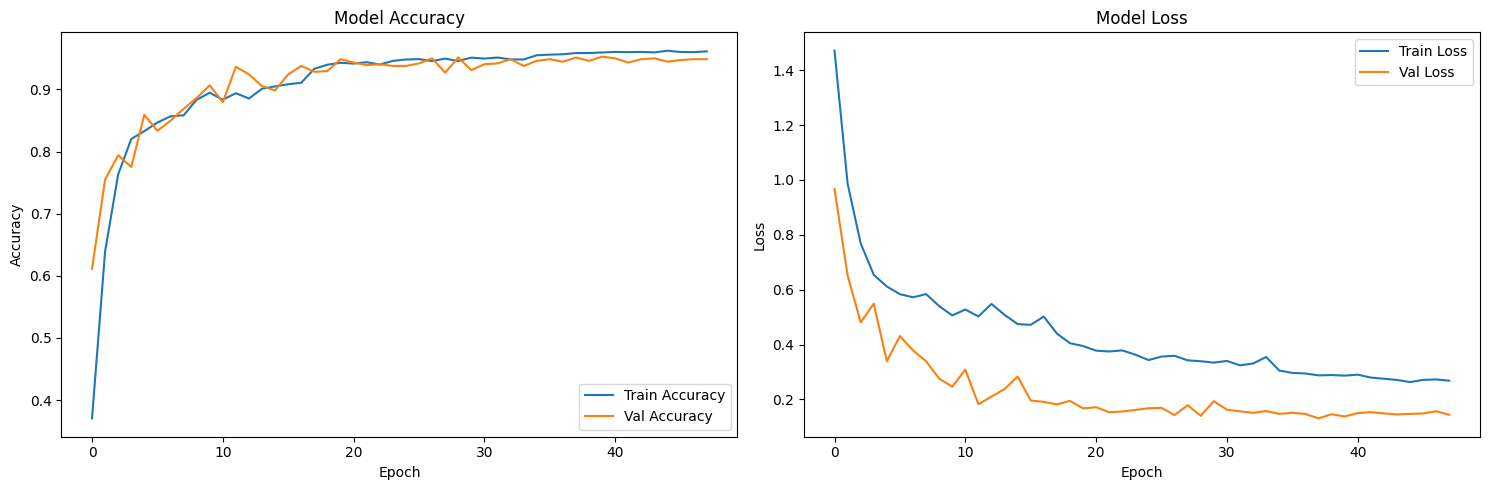


Evaluating model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 543ms/step - accuracy: 0.9617 - loss: 0.1097
Validation Loss: 0.1577
Validation Accuracy: 0.9431

Loading best model weights...


In [24]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

# Evaluate the model
print("\nEvaluating model...")
val_loss, val_accuracy = evaluate_model(model, valData)

# Load the best model weights
print("\nLoading best model weights...")
model.load_weights('best_vit_model.keras')

In [25]:
# Create submission file
print("\nCreating submission file...")
submission_df = create_submission_csv(model, testData, '/kaggle/working/submission.csv')

# Save model architecture and weights separately for easy loading later
print("\nSaving model for future use...")
model.save('/kaggle/working/fruit_quality_vit_complete.keras')


Creating submission file...
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 574ms/step
Submission saved to /kaggle/working/submission.csv

First 10 predictions:
              ImageID  Class
0     testimage_1.jpg      2
1    testimage_10.jpg      0
2   testimage_100.jpg      0
3  testimage_1000.jpg      2
4  testimage_1001.jpg      0
5  testimage_1002.jpg      2
6  testimage_1003.jpg      1
7  testimage_1004.jpg      1
8  testimage_1005.jpg      2
9  testimage_1006.jpg      2

Saving model for future use...



Training completed successfully!
Final validation accuracy: 0.9431
Files saved:
- best_vit_model.keras (best model weights)
- fruit_quality_vit_complete.keras (complete model)
- submission.csv (Kaggle submission)
- class_indices.json (class mappings)

Getting final predictions on validation set...
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 604ms/step

Classification Report:
                      precision    recall  f1-score   support

     banana_overripe       0.94      0.99      0.97       155
         banana_ripe       0.97      0.97      0.97       160
       banana_rotten       0.98      0.95      0.96       220
       banana_unripe       0.99      0.99      0.99       152
tomato_fully_ripened       0.45      1.00      0.62         5
        tomato_green       0.83      0.65      0.73        37
 tomato_half_ripened       0.27      0.33      0.30         9

            accuracy                           0.95       738
           macro avg       0.78      0.84      0.79       738
        weig

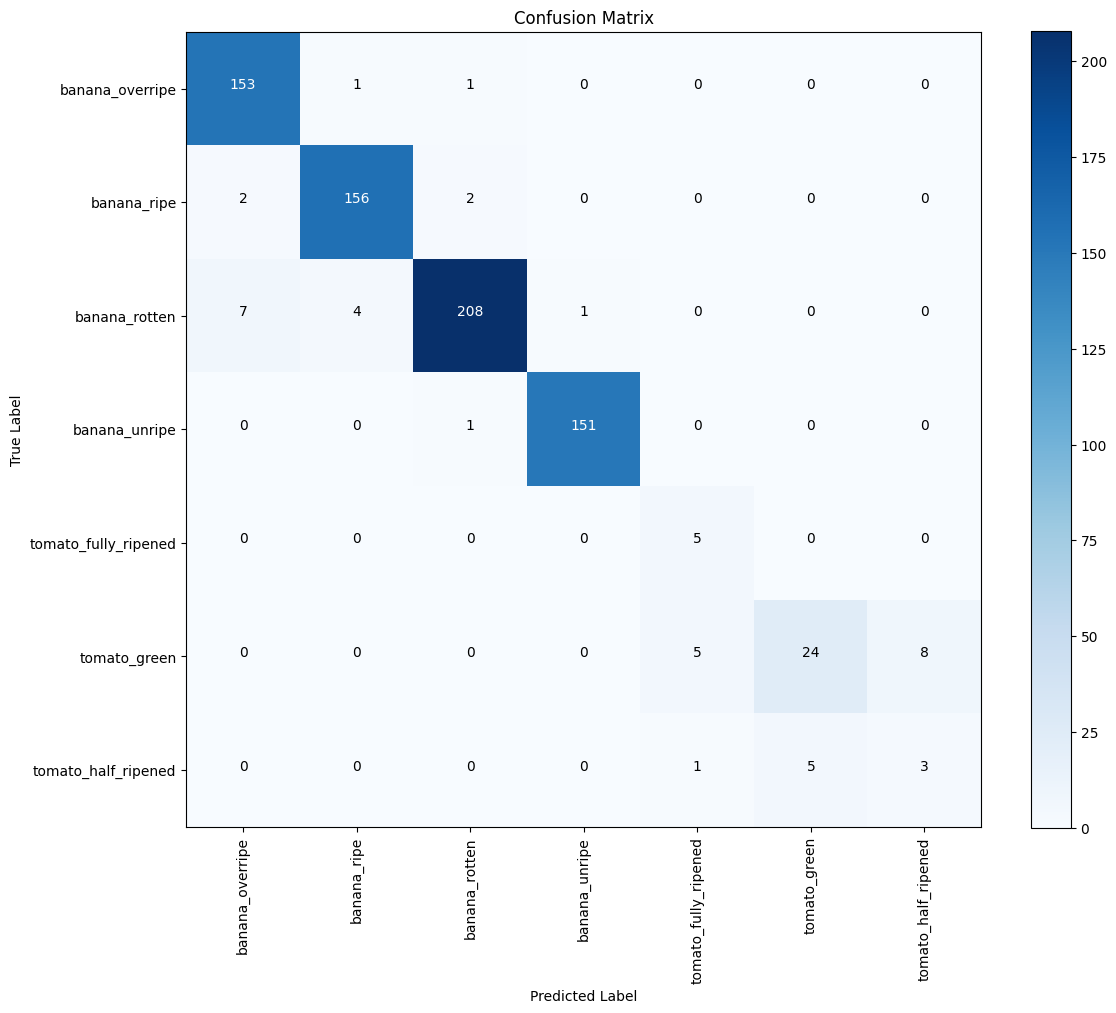

In [26]:
# Save class indices for future reference
import json
class_indices = trainData.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("\nTraining completed successfully!")
print(f"Final validation accuracy: {val_accuracy:.4f}")
print("Files saved:")
print("- best_vit_model.keras (best model weights)")
print("- fruit_quality_vit_complete.keras (complete model)")
print("- submission.csv (Kaggle submission)")
print("- class_indices.json (class mappings)")

# Additional metrics and visualization
print("\nGetting final predictions on validation set...")
val_predictions = model.predict(valData, verbose=1)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Get actual labels for validation set
val_labels = []
for i in range(len(valData)):
    batch_x, batch_y = valData[i]
    val_labels.extend(batch_y)
valData.reset()

val_labels = np.array(val_labels[:len(val_predicted_classes)])

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
class_names = list(trainData.class_indices.keys())

print("\nClassification Report:")
print(classification_report(val_labels, val_predicted_classes, target_names=class_names))

# Confusion matrix
print("\nCreating confusion matrix...")
cm = confusion_matrix(val_labels, val_predicted_classes)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add numbers to confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()